In [17]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# !pip install contractions
# !pip install transformers
import contractions
import re
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:992)>


In [18]:
# train_data = pd.read_csv('train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')

# test_data = pd.read_csv('test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')

# val_data = pd.read_csv('val.txt',header=None,sep=';', names=['Input','Sentiment'], encoding='utf-8')
train_data = pd.read_csv('final_train.csv', encoding='utf-8')
test_data = pd.read_csv('final_test.csv', encoding='utf-8')
val_data = pd.read_csv('final_validate.csv', encoding='utf-8')

train_data.head()

,Input,Sentiment
0,i feel so guilty,sadness
1,i am feeling quite anxious about it all,fear
2,im feeling a little smug this evening,joy
3,one of my very good friends came to me for adv...,anger
4,i feel about the scratches the way i feel abou...,trust


In [19]:
data = {'Train Data': train_data, 'Validation Data': val_data, 'Test Data': test_data}
for temp in data:
    print(temp)
    print(data[temp].isnull().sum())
    print('*'*20)

Train Data
Input        0
Sentiment    0
dtype: int64
********************
Validation Data
Input        0
Sentiment    0
dtype: int64
********************
Test Data
Input        0
Sentiment    0
dtype: int64
********************


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

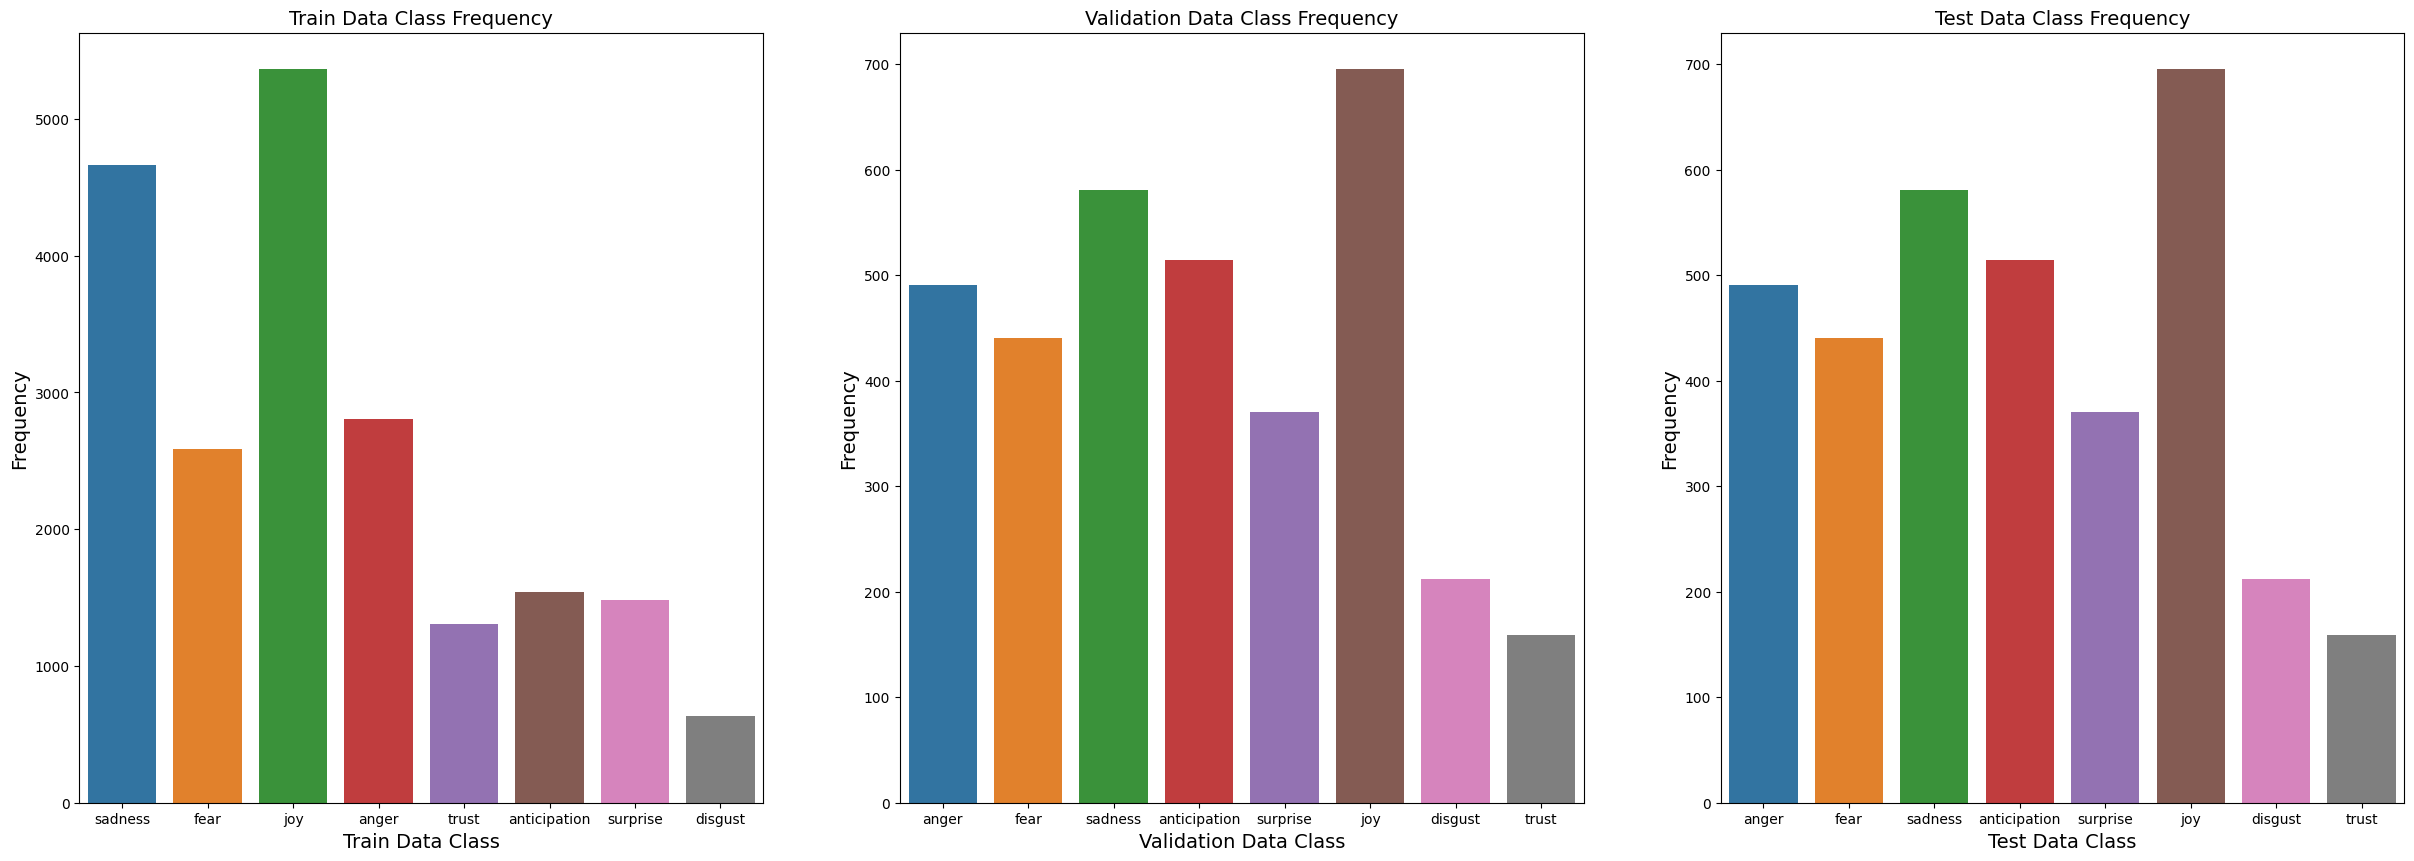

In [20]:
bar, ax = plt.subplots(1,3, figsize=(30, 10))
for index, temp in enumerate(data):
    sns.countplot(ax = ax[index],x = 'Sentiment', data = data[temp])
    ax[index].set_title(temp+' Class Frequency', size=14)
    ax[index].set_ylabel('Frequency', size=14)
    ax[index].set_xlabel(temp+' Class', size=14)

In [5]:
def plot_cloud(wordcloud, temp):
    plt.figure(figsize=(10, 10))
    plt.title(temp+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");

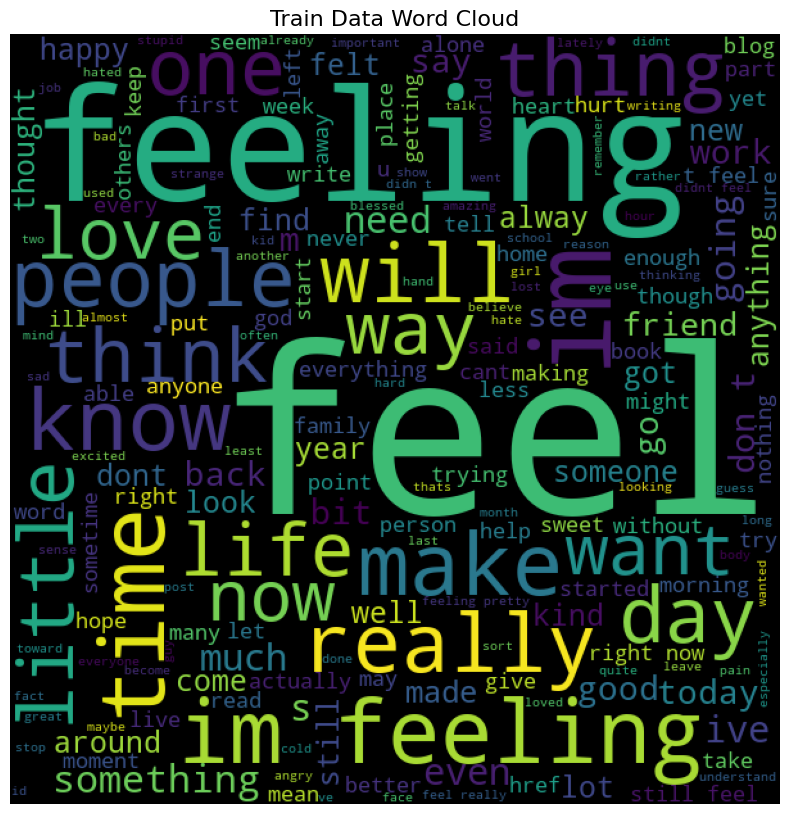

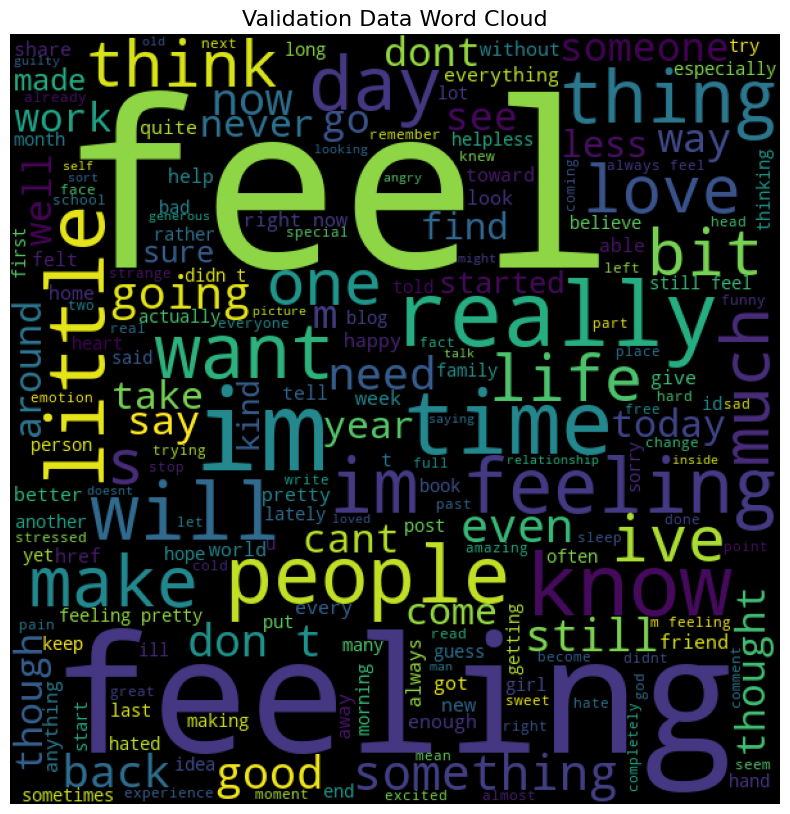

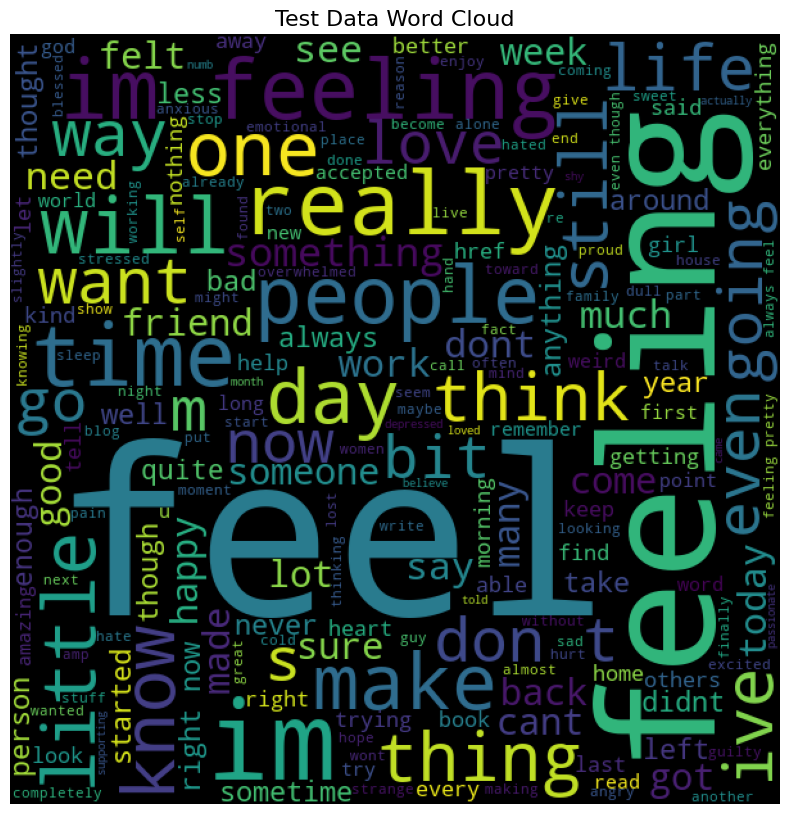

In [6]:
for temp in data:
    temp_text = ' '.join([sentence for sentence in data[temp].Input])
    wordcloud = WordCloud(width = 600, height = 600).generate(temp_text)
    plot_cloud(wordcloud, temp)

In [7]:
def preprocess(sentence):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    sentence = re.sub('[^A-z]', ' ', sentence)
    negative = ['not', 'neither', 'nor', 'but', 'however', 'although', 'nonetheless', 'despite', 'except',
                        'even though', 'yet']
    stop_words = [z for z in stop_words if z not in negative]
    preprocessed_tokens = [lemmatizer.lemmatize(contractions.fix(temp.lower())) for temp in sentence.split() if temp not in stop_words] #lemmatization
    return ' '.join([x for x in preprocessed_tokens]).strip()

In [8]:
train_data['Input'] = train_data['Input'].apply(lambda x: preprocess(x))
val_data['Input'] = val_data['Input'].apply(lambda x: preprocess(x))
test_data['Input'] = test_data['Input'].apply(lambda x: preprocess(x))

In [10]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
train_x, train_y = ros.fit_resample(np.array(train_data['Input']).reshape(-1, 1), np.array(train_data['Sentiment']).reshape(-1, 1))
train = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = ['Input', 'Sentiment'])

In [11]:
from sklearn import preprocessing
le = preprocessing.OneHotEncoder()
y_train= le.fit_transform(np.array(train['Sentiment']).reshape(-1, 1)).toarray()
y_test= le.fit_transform(np.array(test_data['Sentiment']).reshape(-1, 1)).toarray()
y_val= le.fit_transform(np.array(val_data['Sentiment']).reshape(-1, 1)).toarray()

In [12]:
from transformers import RobertaTokenizerFast
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
def roberta_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in range(len(data.Input)):
      encoded = tokenizer.encode_plus(
        
        data.Input[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [14]:
max_len = max([len(x.split()) for x in train_data['Input']])
train_input_ids,train_attention_masks = roberta_encode(train, max_len)
test_input_ids,test_attention_masks = roberta_encode(test_data, max_len)
val_input_ids,val_attention_masks = roberta_encode(val_data, max_len)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [15]:
def create_model(bert_model, max_len):
    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]

    output = tf.keras.layers.Dense(6, activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [16]:
from transformers import TFRobertaModel
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

KeyboardInterrupt: 

In [ ]:
model = create_model(roberta_model, max_len)
model.summary()

In [ ]:
history = model.fit([train_input_ids,train_attention_masks], 
                    y_train, 
                    validation_data=([val_input_ids,val_attention_masks], y_val), 
                    epochs=10,
                    batch_size=100)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
result = model.predict([test_input_ids,test_attention_masks])
y_pred = np.zeros_like(result)
y_pred[np.arange(len(result)), result.argmax(1)] = 1

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy ', accuracy)
f1 = f1_score(y_test, y_pred, average = 'macro')
print('F1 Score :', f1)





In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

In [ ]:
# Save the weights
model.save_weights('my_checkpoint')

In [ ]:
def plot_result(result):
    sns.barplot(x = 'Category', y = 'Confidence', data = result)
    plt.xlabel('Categories', size=14)
    plt.ylabel('Confidence', size=14)
    plt.title('Emotion Classification', size=16)

In [ ]:
def roberta_inference_encode(data,maximum_length) :
    input_ids = []
    attention_masks = []
    
    encoded = tokenizer.encode_plus(
    data,
    add_special_tokens=True,
    max_length=maximum_length,
    pad_to_max_length=True,

    return_attention_mask=True

    )

    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [ ]:
def inference(text_sentence, max_len):
    preprocessed_text = preprocess(text_sentence)
    input_ids, attention_masks = roberta_inference_encode(preprocessed_text, maximum_length = max_len)
    model = create_model(roberta_model, 43)
    model.load_weights('my_checkpoint')
    result = model.predict([input_ids, attention_masks])
    #le.categories_[0] = ['anger' 'fear' 'joy' 'love' 'sadness' 'surprise']
    result = pd.DataFrame(dict(zip(list(le.categories_[0]), [round(x*100, 2)for x in result[0]])).items(), columns = ['Category', 'Confidence'])
    plot_result(result)
    return result

In [ ]:
result = inference("I am unhappy", max_len)
print(result)

In [ ]:
from pyplutchik import plutchik

            
plutchik(result)